In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
import pandas as pd
import math

import warnings
import os

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1
    else:
        return len(geometry.geoms)


def rotate_vector(orig_vector, degree, origin=np.array([0, 0])):
    """
    Rotate a 2-D vector (point) by some given degree. Optionally around a specified origin besides (0,0).
    Supports multiple points.

    Parameters
    ----------
    orig_vector : np.array
                 Original vector(s) of size (2,) or (n,2)
    degree : float
             Counter-clockwise rotation amount in degrees
    origin : np.array
            Origin of rotation
    """
    vector = np.array(orig_vector)
    origin = np.array(origin)

    if vector.ndim == 1:
        vector = np.expand_dims(vector, axis=0)
    vector = vector - origin  # center of circle

    theta = np.radians(degree)
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )

    vector = (rotation_matrix @ vector.T).T
    vector = vector + origin
    return vector


print(rotate_vector([[0, 0], [2, 2]], 270, [1, 1]))


def schwartzberg_score(geom):
    perimeter = geom.length
    area = geom.area

    numerator = 4 * math.pi * area
    denominator = perimeter**2
    score = math.sqrt(numerator / denominator)

    return score


def reock_score(geom):
    geom_area = geom.geometry.area[0]
    min_circle = geom.geometry.minimum_bounding_circle()[0]
    min_circle_area = min_circle.area
    reock_score = geom_area / min_circle_area
    return reock_score

[[ 2.22044605e-16  2.00000000e+00]
 [ 2.00000000e+00 -2.22044605e-16]]


In [6]:
state_dict = dict(
    # az_2020={"districts": 9, "crs": "EPSG:2223"},
    # ca_2020={"districts": 52, "crs": "EPSG:2225"},
    ct_2020={"districts": 5, "crs": "EPSG:2234"},
    # fl_2020={"districts": 28, "crs": "EPSG:2225"},
    # ga_2020={"districts": 14, "crs": "EPSG:2240"},
    # md_2020={"districts": 8, "crs": "EPSG:2248"},
    # mi_2020={"districts": 13, "crs": "EPSG:2252"},
    # mn_2020={"districts": 8, "crs": "EPSG:2811"},
    # nc_2020={"districts": 14, "crs": "EPSG:2264"},
    # nh_2020={"districts": 2, "crs": "EPSG:3437"},
    # nj_2020={"districts": 12, "crs": "EPSG:2824"},
    # nv_2020={"districts": 4, "crs": "EPSG:2821"},
    # oh_2020={"districts": 15, "crs": "EPSG:2834"},
    # or_2020={"districts": 6, "crs": "EPSG:2269"},
    # pa_2020={"districts": 17, "crs": "EPSG:2271"},
    # sc_2020={"districts": 7, "crs": "EPSG:2273"},
    # va_2020={"districts": 11, "crs": "EPSG:2283"},
    # wi_2020={"districts": 8, "crs": "EPSG:2288"},
    # ma_2020={"districts": 9, "crs": "EPSG:2249"},
    # tx_2020={"districts": 38, "crs": "EPSG:2277"},
)

# Load Data

In [7]:
data_path = "../data/mggg-states/"
output_dir = "../output/"
run_name = "moving_knife_both"
seed = 42

pop = "POP20"
d_votes = "USH20_D"
r_votes = "USH20_R"

In [2]:
degrees = np.linspace(0, 359, 36)
degrees

array([  0.        ,  10.25714286,  20.51428571,  30.77142857,
        41.02857143,  51.28571429,  61.54285714,  71.8       ,
        82.05714286,  92.31428571, 102.57142857, 112.82857143,
       123.08571429, 133.34285714, 143.6       , 153.85714286,
       164.11428571, 174.37142857, 184.62857143, 194.88571429,
       205.14285714, 215.4       , 225.65714286, 235.91428571,
       246.17142857, 256.42857143, 266.68571429, 276.94285714,
       287.2       , 297.45714286, 307.71428571, 317.97142857,
       328.22857143, 338.48571429, 348.74285714, 359.        ])

0 ct_2020 5


100%|██████████| 36/36 [00:10<00:00,  3.54it/s]


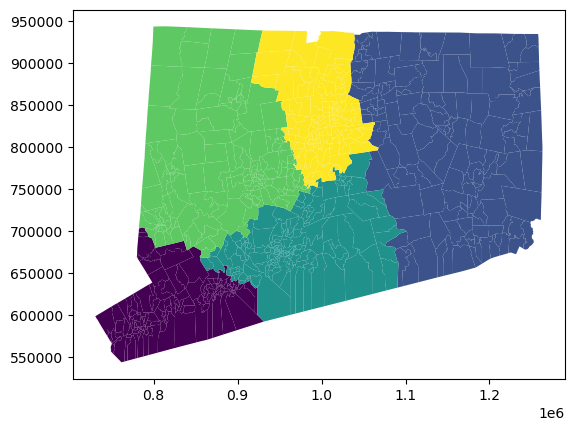

In [8]:
for i, s in enumerate(state_dict.keys()):
    state_file = s #s.split("\\")[-1]
    n_districts = state_dict[state_file]["districts"]
    print(i, state_file, n_districts)
    voting_precincts = gpd.read_file(f"../redistricting/data_prep/output/{s}/")
    orig_columns = list(voting_precincts.columns)

    voting_precincts[d_votes] = voting_precincts[d_votes].fillna(0)
    voting_precincts[r_votes] = voting_precincts[r_votes].fillna(0)
    voting_precincts[pop] = voting_precincts[pop].fillna(0)
    orig_voting = voting_precincts[[d_votes, r_votes]].sum() / (
        voting_precincts[[d_votes, r_votes]].sum().sum()
    )

    voting_precincts["REPRESENTATIVE_POINT"] = voting_precincts.centroid

    voting_precincts["RP_LON"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.x
    )
    voting_precincts["RP_LAT"] = voting_precincts["REPRESENTATIVE_POINT"].apply(
        lambda p: p.y
    )

    df = voting_precincts.copy().reset_index(drop=True)
    df["ORIGINAL_INDEX_"] = df.index
    df["DISTRICT_"] = 0  # Original

    target_pop_ratio = 1 / n_districts
    target_pop = target_pop_ratio * df[pop].sum()
    degrees = np.linspace(0, 359, 36)
    radians = np.radians(degrees)

    holder = []
    step = 1
    while step < n_districts:
        # df will get smaller as algorithm loops (pieces get allocated)
        df["INDEX_"] = df.index
        points = df[["RP_LON", "RP_LAT"]].to_numpy()

        # Create circle of remaining pieces
        state_dissolved = df.dissolve()
        state_min_radius = state_dissolved.geometry.minimum_bounding_radius()[0]
        state_min_circle = state_dissolved.geometry.minimum_bounding_circle()[0]
        state_min_circle_o = state_min_circle.centroid
        origin = np.array([state_min_circle_o.x, state_min_circle_o.y])

        # Loop through each degree point
        degrees_tracker = []
        for degree in tqdm(degrees):
            df = df.sort_values(by="INDEX_").reset_index(drop=True)
            df["NEW_DISTRICT_"] = 0

            rotated_points = rotate_vector(points, 360 - degree, origin)
            df["ROTATED_LON"] = rotated_points[:, 0]
            df = df.sort_values(by="ROTATED_LON").reset_index(drop=True)
            i = 0
            captured_pop = 0
            while captured_pop < target_pop:
                captured_pop += df.loc[i, pop]
                i += 1
            # Check for Inclusivity
            pop_check1 = df.iloc[: i - 1][pop].sum()
            pop_check2 = df.iloc[:i][pop].sum()
            inclusive = (
                True
                if abs(pop_check1 - target_pop) > abs(pop_check2 - target_pop)
                else False
            )
            if inclusive:
                df.loc[: i - 1, "NEW_DISTRICT_"] = 1
            else:
                df.loc[: i - 2, "NEW_DISTRICT_"] = 1

            df_a = df.loc[df["NEW_DISTRICT_"] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df["NEW_DISTRICT_"] != 1].copy().reset_index(drop=True)

            df_a_compactness = reock_score(df_a.dissolve())
            df_b_compactness = reock_score(df_b.dissolve())
            mean_compactness = (df_a_compactness + df_b_compactness) / 2

            degrees_tracker.append(
                {
                    "degree": degree,
                    "pieces": i,
                    "inclusive": inclusive,
                    "population": captured_pop,
                    "compactness": mean_compactness,
                }
            )

        degrees_tracker = pd.DataFrame(degrees_tracker)
        degrees_tracker = degrees_tracker.sort_values(
            by="compactness", ascending=False
        ).reset_index(drop=True)
        optimal_choice = degrees_tracker.iloc[0]

        df = df.sort_values(by="INDEX_").reset_index(drop=True)
        rotated_points = rotate_vector(points, 360 - optimal_choice["degree"], origin)
        df["ROTATED_LON"] = rotated_points[:, 0]
        df = df.sort_values(by="ROTATED_LON").reset_index(drop=True)
        if optimal_choice["inclusive"]:
            df.loc[: optimal_choice["pieces"] - 1, "DISTRICT_"] = step
        else:
            df.loc[: optimal_choice["pieces"] - 2, "DISTRICT_"] = step

        holder.append(df.loc[df["DISTRICT_"] == step])
        df = df.loc[df["DISTRICT_"] == 0]  # So far unused.
        step += 1

    # Final
    df["DISTRICT_"] = step
    holder.append(df)

    all_districts = pd.concat(holder).reset_index(drop=True)
    all_districts.plot(column="DISTRICT_")
    os.makedirs(os.path.join(output_dir, state_file), exist_ok=True)
    all_districts[orig_columns + ["DISTRICT_"]].to_file(os.path.join(output_dir, state_file,f"{state_file}_{run_name}.shp"))

<Axes: >

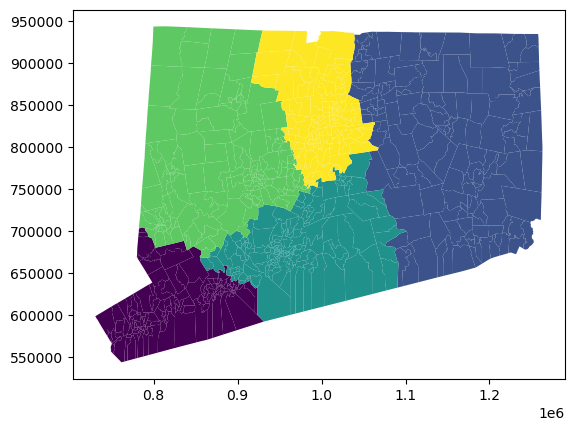

In [9]:
all_districts.plot(column="DISTRICT_")


In [10]:
pop_summary = all_districts.groupby("DISTRICT_").sum()[pop].reset_index()
pop_summary['pct_deviation'] = (pop_summary[pop] - (pop_summary[pop].sum()/n_districts))/(pop_summary[pop].sum()/n_districts)*100
pop_summary

,DISTRICT_,POP20,pct_deviation
0,1,719171.0,-0.279788
1,2,724138.0,0.408936
2,3,720815.0,-0.051831
3,4,719535.0,-0.229316
4,5,722285.0,0.151999


In [11]:
voting_share = all_districts.groupby('DISTRICT_')[['USH20_D','USH20_R']].sum().reset_index()
voting_share["Dem_Ratio"] = round(voting_share["USH20_D"]/(voting_share["USH20_R"]+voting_share["USH20_D"]),2)
voting_share.sort_values(by="Dem_Ratio").reset_index()

,index,DISTRICT_,USH20_D,USH20_R,Dem_Ratio
0,3,4,173988,169115,0.51
1,2,3,204374,138696,0.60
2,1,2,211684,137990,0.61
3,4,5,214178,116202,0.65
4,0,1,218436,114629,0.66
